In [1]:
from __future__ import absolute_import, division, print_function
from matplotlib.pyplot import GridSpec
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs

import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import os, sys
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set_context("poster", font_scale=1.3)

import missingno as msno
import pandas_profiling

import time

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
df = pd.read_csv("redcard.csv")   

In [3]:
df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


### 创建球员和裁判的数据表

In [4]:
dyad_index = ['refNum', 'playerShort']        # 设置索引
dyad_cols = ['games',                         # 设置列名
             'victories',
             'ties',
             'defeats',
             'goals',
             'yellowCards',
             'yellowReds',
             'redCards',
             'rater1',
             'rater2'
            ]

In [5]:
def get_subgroup(dataframe, g_index, g_columns):
    
    g = dataframe.groupby(g_index).agg({col:'nunique' for col in g_columns})
    if g[g > 1].dropna().shape[0] != 0:
        print("存在不唯一的值！")
    return dataframe.groupby(g_index).agg({col:'max' for col in g_columns})

In [6]:
dyads = get_subgroup(df, g_index=dyad_index, g_columns=dyad_cols)       # 调用之前的函数去掉重复值

In [7]:
dyads.head()

games  victories  ties  defeats  goals  yellowCards  \
refNum playerShort                                                          
1      lucas-wilchez      1          0     0        1      0            0   
2      john-utaka         1          0     0        1      0            1   
3      abdon-prats        1          0     1        0      0            1   
       pablo-mari         1          1     0        0      0            0   
       ruben-pena         1          1     0        0      0            0   

                      yellowReds  redCards  rater1  rater2  
refNum playerShort                                          
1      lucas-wilchez           0         0    0.25    0.50  
2      john-utaka              0         0    0.75    0.75  
3      abdon-prats             0         0     NaN     NaN  
       pablo-mari              0         0     NaN     NaN  
       ruben-pena              0         0     NaN     NaN

In [8]:
dyads = dyads[dyads.rater1.notnull()]

In [9]:
dyads['skintone'] = dyads[['rater1', 'rater2']].mean(axis=1) # 新增加一列表示两个指标的平均值即肤色值
dyads.head()

games  victories  ties  defeats  goals  \
refNum playerShort                                                  
1      lucas-wilchez           1          0     0        1      0   
2      john-utaka              1          0     0        1      0   
4      aaron-hughes            1          0     0        1      0   
       aleksandar-kolarov      1          1     0        0      0   
       alexander-tettey        1          0     0        1      0   

                           yellowCards  yellowReds  redCards  rater1  rater2  \
refNum playerShort                                                             
1      lucas-wilchez                 0           0         0    0.25    0.50   
2      john-utaka                    1           0         0    0.75    0.75   
4      aaron-hughes                  0           0         0    0.25    0.00   
       aleksandar-kolarov            0           0         0    0.00    0.25   
       alexander-tettey              0           0         0    1.00    1.00   

                           skintone  
refNum playerShort                   
1      lucas-wilchez          0.375  
2      john-utaka             0.750  
4      aaron-hughes           0.125  
       aleksandar-kolarov     0.125  
       alexander-tettey       1.000

In [10]:
dyads.shape

(124621, 11)

In [11]:
dyads[dyads.redCards > 1].head(10)  # 查看那些球员的红牌数大于 1 

games  victories  ties  defeats  goals  yellowCards  \
refNum playerShort                                                              
140    bodipo                 6          2     1        3      1            0   
367    antonio-lopez_2        8          5     2        1      0            2   
432    javi-martinez         14          4     3        7      2            2   
       jonas                  9          1     4        4      1            0   
487    phil-jagielka          7          2     1        4      1            0   
586    cyril-jeunechamp      14          8     0        6      0            6   
804    sergio-ramos          18         12     1        5      4            6   
985    aly-cissokho           9          1     5        3      1            1   
1114   eugen-polanski         8          4     0        4      0            0   
1214   emmanuel-adebayor     23          9     7        7     10            4   

                          yellowReds  redCards  rater1  rater2  skintone  
refNum playerShort                                                        
140    bodipo                      0         2    0.50    0.25     0.375  
367    antonio-lopez_2             0         2    0.25    0.25     0.250  
432    javi-martinez               0         2    0.00    0.00     0.000  
       jonas                       0         2    0.25    0.25     0.250  
487    phil-jagielka               0         2    0.25    0.25     0.250  
586    cyril-jeunechamp            0         2    0.00    0.00     0.000  
804    sergio-ramos                1         2    0.00    0.00     0.000  
985    aly-cissokho                0         2    1.00    1.00     1.000  
1114   eugen-polanski              0         2    0.00    0.00     0.000  
1214   emmanuel-adebayor           1         2    1.00    1.00     1.000

In [ ]:
pd.DataFrame(dyads).to_csv("dyads.csv", encoding="utf_8_sig")  # 将处理后的数据另存为Players.csv文件

In [12]:
agg_dyads = pd.read_csv("dyads.csv")
agg_dyads.head(10)

,refNum,playerShort,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,rater1,rater2,skintone
0,1,lucas-wilchez,1,0,0,1,0,0,0,0,0.25,0.50,0.375
1,2,john-utaka,1,0,0,1,0,1,0,0,0.75,0.75,0.750
2,4,aaron-hughes,1,0,0,1,0,0,0,0,0.25,0.00,0.125
3,4,aleksandar-kolarov,1,1,0,0,0,0,0,0,0.00,0.25,0.125
4,4,alexander-tettey,1,0,0,1,0,0,0,0,1.00,1.00,1.000
5,4,anders-lindegaard,1,0,1,0,0,0,0,0,0.25,0.25,0.250
6,4,andreas-beck,1,1,0,0,0,0,0,0,0.00,0.00,0.000
7,4,antonio-rukavina,2,2,0,0,0,1,0,0,0.00,0.00,0.000
8,4,ashkan-dejagah,1,1,0,0,0,0,0,0,0.50,0.50,0.500
9,4,benedikt-hoewedes,1,1,0,0,0,0,0,0,0.00,0.00,0.000


In [13]:
agg_dyads['totalRedCards'] = agg_dyads['yellowReds'] + agg_dyads['redCards']       # 将黄牌和红牌的数量进行汇总
agg_dyads.rename(columns={'redCards': 'strictRedCards'}, inplace=True)

In [14]:
colus = ['refNum','playerShort','totalRedCards','skintone']
agg_dyads2 = agg_dyads[colus]
agg_dyads2

,refNum,playerShort,totalRedCards,skintone
0,1,lucas-wilchez,0,0.375
1,2,john-utaka,0,0.750
2,4,aaron-hughes,0,0.125
3,4,aleksandar-kolarov,0,0.125
4,4,alexander-tettey,0,1.000
...,...,...,...,...
124616,3147,tomas-rosicky,0,0.000
124617,3147,winston-reid,0,0.375
124618,3147,xherdan-shaqiri,0,0.250
124619,3147,yassine-el-ghanassi,0,0.500


In [15]:
agg_dyads3 = agg_dyads2.reset_index().set_index(['refNum','playerShort'])#同时以 refNum 和 playerShort 为索引
agg_dyads4 = agg_dyads3.drop(['index'], axis=1)

In [16]:
(agg_dyads4.groupby(level=0)      #以 refNum 为索引，统计出每个裁判所给的红牌和黄牌数
           .sum()
           .sort_values('totalRedCards', ascending=False)).head()#以降序排列 

,totalRedCards,skintone
refNum,,
468,49,139.500
432,49,121.250
449,47,184.250
916,42,137.875
2073,36,107.625


In [17]:
(agg_dyads4.groupby(level=1)        #以 playerShort 为索引，统计每个球员得到的红牌和黄牌总数
           .sum()
           .sort_values('totalRedCards', ascending=False)).head()

,totalRedCards,skintone
playerShort,,
cyril-jeunechamp,19,0.000
sergio-ramos,19,0.000
gary-medel,16,14.625
ballesteros,15,27.500
juanfran,15,56.625


In [18]:
b = pd.concat([agg_dyads4.sample(replace=True, n=10000).groupby('skintone').mean() 
                      for _ in range(100)])
#以肤色为键进行分组，分别计算每列数据的均值，循环执行100次

Text(0.5, 0, 'Skintone')

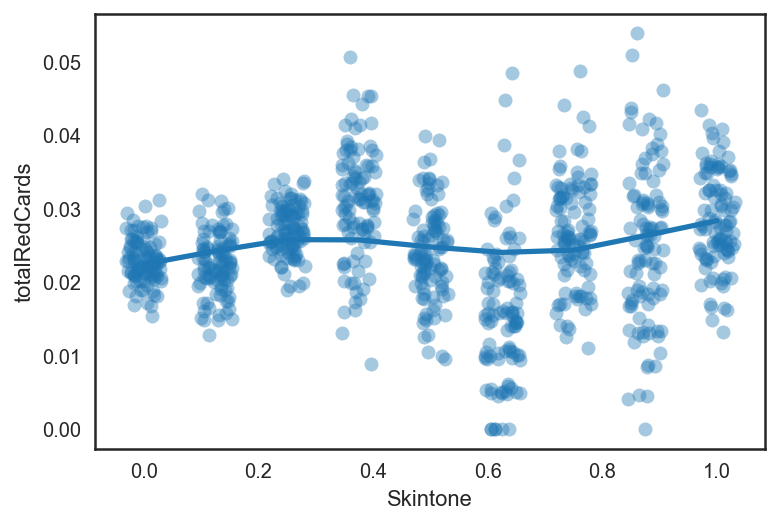

In [19]:
#绘制红牌、黄牌总数和球员肤色之间的关系图
ax = sns.regplot(b.index.values,
                 y='totalRedCards',
                 data=b,
                 lowess=True,
                 scatter_kws={'alpha':0.4,},
                 x_jitter=(0.125 / 4.0))
ax.set_xlabel("Skintone")

&#8194;&#8194;&#8194;&#8194;从图中可以看出当肤色值较小时，红、黄牌总数分布比较均匀，值比较小；当肤色值比较大时，红、黄牌总数分布比较分散，值相对较高。可以看出有的裁判较倾向于白人球员，对于肤色较深的球员有些歧视，如黑人。